# Best Days to Host an Outdoor Party at the Code Louisville Office

Libraries

In [2]:
import requests
import pandas as pd
import sqlite3
from datetime import date
import calendar
import matplotlib.pyplot as plt

In [3]:
DS_API_KEY = "00b999d3b38cbf3fd6f7c14b01244f79"
LAT = 38.2535367
LONG = -85.7481863

### loop to pull all dates to target for project

In [4]:
# Returns all Saturdays, Sundays, and Holiday Mondays in 2019
potential_dates = []
year = 2019
c = calendar.TextCalendar(calendar.SUNDAY)
for m in range(1,13):
    for i in c.itermonthdays(year,m):
        if i != 0:                                      #calendar constructs months with leading zeros (days belongng to the previous month)
            day = date(year,m,i)
            if day.weekday() == 0:
                if m == 2 and 15<= i <= 21: #third Monday
                    potential_dates.append("{}-0{}-{}, President's Day".format(year,m,i))
                if m == 5 and 25 <= i <=31: #last monday of May
                    potential_dates.append("{}-0{}-{}, Memorial Day".format(year,m,i))
                if m == 9 and 1 <= i <=7: #1st Monday
                    potential_dates.append("{}-0{}-0{}, Labor Day".format(year,m,i))
                if m == 10 and 8 <= i <=14: #2nd Monday
                    potential_dates.append("{}-{}-{}, Columbus Day*".format(year,m,i))
                if m == 10 and 22 <= i <=28: #4th Monday
                    potential_dates.append("{}-{}-{}, Veterans Day".format(year,m,i))
            if day.weekday() == 5 or day.weekday() == 6: #if its Saturday or Sunday
                if m < 10:
                    if i < 10:
                        potential_dates.append("{}-0{}-0{}".format(year,m,i))
                    else:
                        potential_dates.append("{}-0{}-{}".format(year,m,i))
                elif m > 9 and i <10:
                    potential_dates.append("{}-{}-0{}".format(year,m,i))
                else:
                    potential_dates.append("{}-{}-{}".format(year,m,i))
 


print(potential_dates)

['2019-01-05', '2019-01-06', '2019-01-12', '2019-01-13', '2019-01-19', '2019-01-20', '2019-01-26', '2019-01-27', '2019-02-02', '2019-02-03', '2019-02-09', '2019-02-10', '2019-02-16', '2019-02-17', "2019-02-18, President's Day", '2019-02-23', '2019-02-24', '2019-03-02', '2019-03-03', '2019-03-09', '2019-03-10', '2019-03-16', '2019-03-17', '2019-03-23', '2019-03-24', '2019-03-30', '2019-03-31', '2019-04-06', '2019-04-07', '2019-04-13', '2019-04-14', '2019-04-20', '2019-04-21', '2019-04-27', '2019-04-28', '2019-05-04', '2019-05-05', '2019-05-11', '2019-05-12', '2019-05-18', '2019-05-19', '2019-05-25', '2019-05-26', '2019-05-27, Memorial Day', '2019-06-01', '2019-06-02', '2019-06-08', '2019-06-09', '2019-06-15', '2019-06-16', '2019-06-22', '2019-06-23', '2019-06-29', '2019-06-30', '2019-07-06', '2019-07-07', '2019-07-13', '2019-07-14', '2019-07-20', '2019-07-21', '2019-07-27', '2019-07-28', '2019-08-03', '2019-08-04', '2019-08-10', '2019-08-11', '2019-08-17', '2019-08-18', '2019-08-24', '2

### API call with nested *Summary* data to SQL DB and .csv

In [5]:
def request_loop(list,year,years_back):
    starting_year = int(year)- years_back
    ending_year = int(year)
    mm_dd_list =[]
    year_list =[]
    #pull out list item by index
    for target_day in list:
        if len(target_day)> 10:
            mm_dd = target_day[5:10]
        else:
            mm_dd = target_day[5:]
        for year in range(starting_year, ending_year):
            try:
                dark_sky_request = requests.get("https://api.darksky.net/forecast/" + DS_API_KEY + "/" + LAT +"," + LONG + "," + str(year) + "-" + mm_dd + "T00:00:00?exclude=currently,flags,alerts")
                if target_day == list[0] and year == starting_year:
                    weather_summary_dataframe = pd.DataFrame.from_dict(dark_sky_request.json()['daily']['data'], orient = 'columns')
                else:
                    weather_summary_dataframe = weather_summary_dataframe.append(pd.DataFrame.from_dict(dark_sky_request.json()['daily']['data'], orient = 'columns'))
                mm_dd_list.append(mm_dd)
                year_list.append(str(year))
            except KeyError:
                print(str(year)+ '-' + mm_dd)
                continue
    weather_summary_dataframe["MM_DD"]= mm_dd_list
    weather_summary_dataframe["Year"]= year_list
    weather_summary_dataframe.to_csv('weather_summary_dataframe.csv')
    weather_summary_dataframe.to_sql("weather summary",sqlite3.connect("Weather_summary.db"), if_exists ="replace")
    return weather_summary_dataframe

# Option 1a:  Uncomment 'request_loop()' below to run the full loop.
### Running the loop is completely optional.  The data has already been saved and provided in this repo.  
# Option 1b:  Choose how many years of weather history you'd like the dataset to accumulate
### Define 'years_back' variable as an integer between 1 and 9 
#### (any more than that and I get charged by dark sky!)

In [6]:
#how many years of weather history would you like to use to determine our best party day choices?
years_back = 10
#request_loop(potential_dates,2019,years_back)

# Option 2:  Leave the above cell as is and run the remaining cells

In [7]:
#  command for adding csv to weather_summary.db
weather_summary_dataframe = pd.read_csv('weather_summary_dataframe.csv')
weather_summary_dataframe.to_sql("weather_summary",sqlite3.connect("weather_summary.db"), if_exists ="replace")


C:\Users\james\Anaconda3\lib\site-packages\pandas\core\generic.py:2130: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  dtype=dtype)


#### Pulls needed counts of precipitation history data from SQL DB for visualization, groups counts by MM_DD

In [8]:
precip_days = pd.read_sql_query("SELECT MM_DD, precipType FROM 'weather_summary' WHERE precipType != 'None'", sqlite3.connect("weather_summary.db"))
precip_count = precip_days.groupby('MM_DD').count()
precip_count.head()

,precipType
MM_DD,
01-05,2
01-06,1
01-12,6
01-13,4
01-19,2


#### Pulls avg temps grouped by MM_DD

In [9]:
hi_low_days = pd.read_sql_query("SELECT MM_DD, apparentTemperatureHigh, apparentTemperatureLow FROM 'weather_summary'",sqlite3.connect("weather_summary.db"))
avg_hi_low_days = hi_low_days.groupby('MM_DD').mean()
avg_hi_low_days.head()

,apparentTemperatureHigh,apparentTemperatureLow
MM_DD,,
01-05,35.192,18.625
01-06,30.790,16.188
01-12,41.668,24.698
01-13,34.858,22.158
01-19,41.471,29.881


#### Merges Avg temps with precip counts

In [10]:
#avg_days = avg_hi_days.merge(avg_low_days, on ='MM_DD')
avg_days_precip_count = avg_hi_low_days.merge(precip_count, on ='MM_DD')
avg_days_precip_count.head()

,apparentTemperatureHigh,apparentTemperatureLow,precipType
MM_DD,,,
01-05,35.192,18.625,2
01-06,30.790,16.188,1
01-12,41.668,24.698,6
01-13,34.858,22.158,4
01-19,41.471,29.881,2


### Option 1:  Choose your ideal temp range (in ℉) below 
### OR
### Option 2:  Run the cell below as is

In [40]:
max_high_temp = 80 
min_low_temp = 50

#### Filters out Average Temps by 'max_high_temp', and 'min_low_temp'

In [41]:
ideal_days = avg_days_precip_count.loc[(avg_days_precip_count.apparentTemperatureHigh < max_high_temp) & (avg_days_precip_count.apparentTemperatureLow > min_low_temp)] 
ideal_days.head()

,apparentTemperatureHigh,apparentTemperatureLow,precipType
MM_DD,,,
04-13,73.729,52.471,2
04-14,71.516,52.751,5
04-27,69.530,52.371,6
04-28,70.164,52.221,7
05-04,71.899,53.745,6


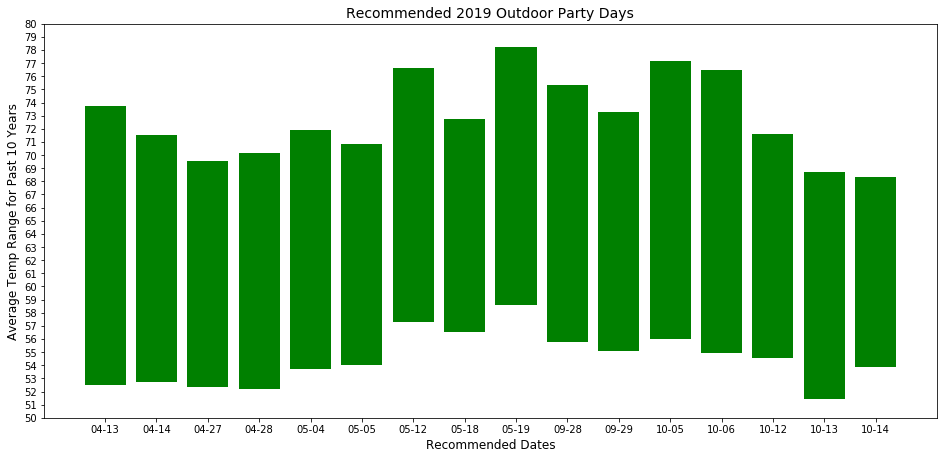

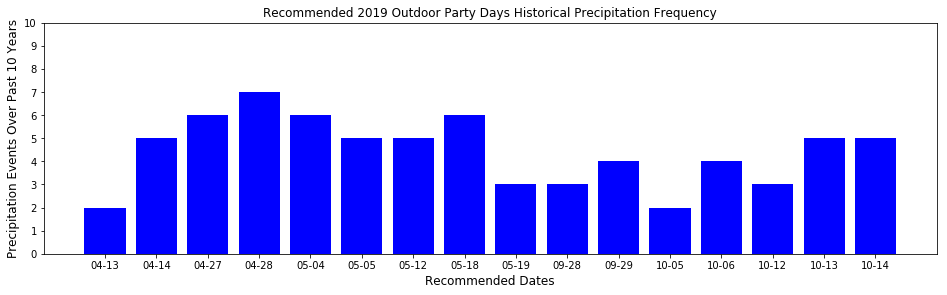

In [42]:
# determines ticks based on desired temp range
temp_range_yticks =[]
for num in range(min_low_temp, (max_high_temp+1)):
        temp_range_yticks.append(num)
# determines ticks based on desired years of weather history
precip_yticks=[]
for num in range(years_back+1):
    precip_yticks.append(num)

plt.figure(figsize=(len(ideal_days), 7.25))
plt.title("Recommended 2019 Outdoor Party Days", fontsize = 14)
plt.xlabel("Recommended Dates", fontsize = 12)
plt.ylabel("Average Temp Range for Past " + str(years_back) + " Years", fontsize = 12)
plt.yticks(temp_range_yticks)
plt.ylim(min_low_temp, max_high_temp)
plt.bar(ideal_days.index, ideal_days.apparentTemperatureHigh, color = "green", label='Avg Temp Range')
plt.bar(ideal_days.index, ideal_days.apparentTemperatureLow, color = "white")# 'white' hides low bars, thereby giving the desired 'floating bar' effect I was shooting for.
plt.show()

plt.figure(figsize=(len(ideal_days), 4.25))
plt.title("Recommended 2019 Outdoor Party Days Historical Precipitation Frequency")
plt.xlabel("Recommended Dates", fontsize = 12)
plt.ylabel("Precipitation Events Over Past "+ str(years_back) + " Years", fontsize = 12)
plt.yticks(precip_yticks)
plt.ylim(0,years_back)
plt.bar(ideal_days.index, ideal_days.precipType, color = "blue")
plt.show()
